**SUPERCOMPUTAÇÃO - AVALIAÇÃO FINAL - 13/06/2022**

**NOME:** 

**QUESTÃO 1.** Resolva a questão 1 no espaço de código abaixo... você pode duplicá-lo quantas vezes forem necessárias. 

In [ ]:
#include <iostream>
#include <vector>
#include <algorithm>
#include <random>
#include <cstdlib>
#include <cmath>
#include <omp.h>

using namespace std;

int main() {

    int n = 1000;
    vector<int> vector_of_numbers(n);

    for (int i = 0; i < n; i++) {
        random_device random;
        mt19937 generator(random());
        uniform_int_distribution<int> distribution(1,999);
        vector_of_numbers[i] = distribution(generator);
    }

    int sum = 0;
    int average = 0;
    int standard_deviation = 0;

    #pragma omp parallel for reduction(+:sum) num_threads(2)
    for (int i = 0; i < n; i++) {
        sum+= vector_of_numbers[i];
    }

    average = sum / n;

    cout << average << endl;

    #pragma omp parallel for reduction(+:standard_deviation) num_threads(2)
    for (int i = 0; i < n; i++) {
        standard_deviation+= pow(vector_of_numbers[i] - average, 2);
    }

    standard_deviation = standard_deviation / n;
    standard_deviation = sqrt(standard_deviation);
    cout << standard_deviation;

}

<AxesSubplot:xlabel='in'>

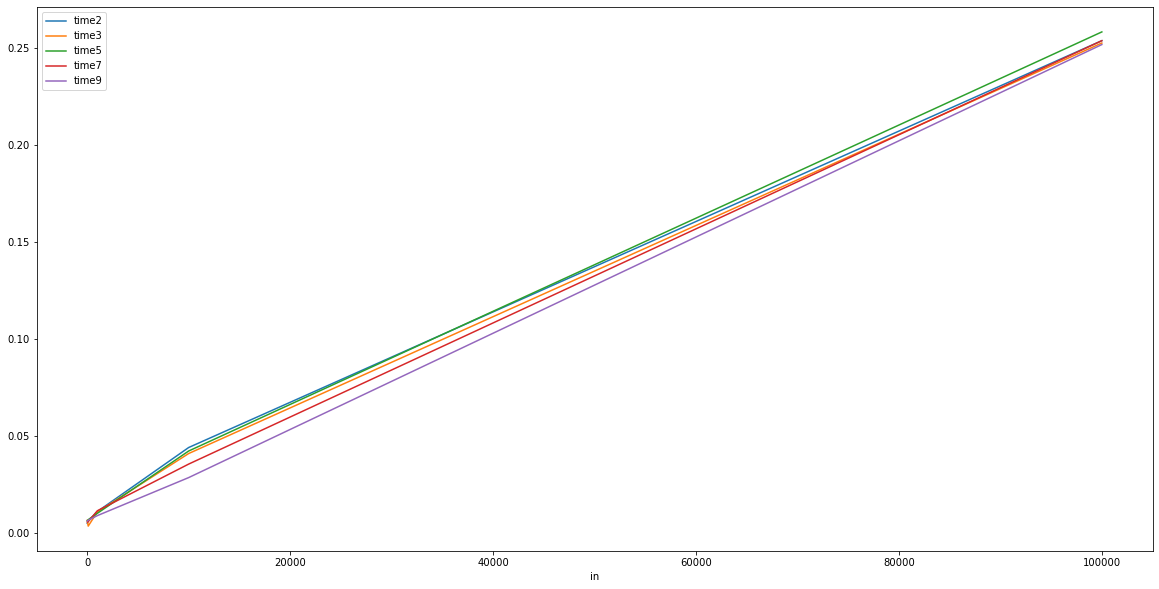

In [15]:
import matplotlib.pyplot as plt

import pandas as pd

standard_deviation_2_threads = {"standard_deviation": [249, 293, 281, 289, 0], "time2": [0.0051, 0.0063, 0.0112, 0.0442, 0.2539], "in":[10, 100, 1000, 10000, 100000]}
standard_deviation_3_threads = {"standard_deviation": [291, 315, 286, 288, 146], "time3": [0.0067, 0.0037, 0.0110, 0.0411, 0.2527], "in":[10, 100, 1000, 10000, 100000]}
standard_deviation_5_threads = {"standard_deviation": [213, 273, 295, 288, 0], "time5": [0.0065, 0.0070, 0.01028, 0.0424, 0.25842], "in":[10, 100, 1000, 10000, 100000]}
standard_deviation_7_threads = {"standard_deviation": [250, 280, 292, 288, 0], "time7": [0.0058, 0.0060, 0.0116, 0.03566, 0.2539], "in":[10, 100, 1000, 10000, 100000]}
standard_deviation_9_threads = {"standard_deviation": [183, 295,287, 286, 0], "time9": [0.0063, 0.0067, 0.0091, 0.0287,0.2519], "in":[10, 100, 1000, 10000, 100000]}
                                
df_2 = pd.DataFrame.from_dict(standard_deviation_2_threads)
df_3 = pd.DataFrame.from_dict(standard_deviation_3_threads)
df_5 = pd.DataFrame.from_dict(standard_deviation_5_threads)
df_7 = pd.DataFrame.from_dict(standard_deviation_7_threads)
df_9 = pd.DataFrame.from_dict(standard_deviation_9_threads)
ax = df_2.plot(x='in', y="time2", figsize=(20,10))
df_3.plot(ax=ax, x='in', y="time3")
df_5.plot(ax=ax, x='in', y="time5")
df_7.plot(ax=ax, x='in', y="time7")
df_9.plot(ax=ax, x='in', y="time9")

Com o gráfico acima é possível verificar que não existe uma melhora tão significativa com o aumento das threads mas sim uma melhora pouco perceptiva que não muda muito o resultado do tempo do número de threads de dois para nove. Fiz o teste para verificar se o código não estava rodando com o openMP na minha máquina local jogando o código para o colab mas basicamente obtive resultados semelhantes.

**FEEDBACK QUESTÃO 1**: Não preencher este campo. Ele será preenchido pelo seu professor durante a correção. 

**QUESTÃO 2.** Resolva a questão 2 no espaço de código abaixo... você pode duplicá-lo quantas vezes forem necessárias. 

**FEEDBACK QUESTÃO 2**: Não preencher este campo. Ele será preenchido pelo seu professor durante a correção. 

In [18]:
%%writefile question2.cu

#include <thrust/host_vector.h>
#include <thrust/device_vector.h>
#include <thrust/generate.h>
#include <thrust/functional.h>
#include <thrust/copy.h>
#include <cstdlib>
#include <algorithm>
#include <iostream>
#include <iomanip>

using namespace  std;

struct saxpy
{
    int a;    
    saxpy(int a_) : a(a_) {};
    __host__ __device__
    double operator()(const int& x, const int& y) {
           return a * x + y;
    }
};

int main(int argc, char* argv[]) {
     if (argc != 3) {
         cerr <<
          "***Numero incorreto de argumentos ***\n";
         return 1;
     }

     int n = atoi(argv[1]);
     int m = atoi(argv[2]);

     //gerar numeros aleatorios
     thrust::host_vector<int> a(n);
     thrust::host_vector<int> b(n);
     thrust::host_vector<int> c(n);
     thrust::generate(a.begin(), a.end(), rand);
     thrust::generate(b.begin(), b.end(), rand);

     //transferimos para a GPU
     thrust::device_vector<int> d_a = a;
     thrust::device_vector<int> d_b = b;

     //transformacao

     thrust::transform(d_a.begin(), d_a.end(),
                       d_b.begin(), d_b.end(),
                       saxpy(m));

     thrust::copy(d_b.begin(), d_b.end(),
     c.begin()); 

     for (int i = 0; i < n; i++ )
         cout << setw(6) << c[i] << " = " 
          << setw(2) << m
          << "*" << setw(5) << a[i]
          << "+" << setw(5) << b[i]
          << endl;

}

Writing question2.cu


In [21]:
%%writefile question2_omp.cpp

#include <iostream>
#include <vector>
#include <algorithm>
#include <random>
#include <cmath>
#include <cstdlib>
#include <iomanip>

using namespace std;

int main(int argc, char* argv[]) {

    if (argc != 4) {
        cerr <<
        "***Numero incorreto de argumentos ***\n";
        return 1;
    }

    int n = atoi(argv[1]);
    int m = atoi(argv[2]);
    int seed = atoi(argv[3]);

    vector<int> data_a(n);
    vector<int> data_b(n);
    vector<int> data_c(n);

    default_random_engine generator;
    generator.seed(seed);
    uniform_int_distribution<int> distribution(1, 999999);

    #pragma omp parallel num_threads(32)
    {
        #pragma omp master
        {
            #pragma omp task
            {
                for (int i = 0; i < n; i++) {
                    data_a[i] = distribution(generator);
                }
            }
            #pragma omp task
            {
                for (int i = 0; i < n; i++) {
                    data_b[i] = distribution(generator);
                }
            }
        }
    }

    #pragma omp parallel for num_threads(32)
    for(int i = 0; i < n; i++) {
        data_c[i] = m * data_a[i] + data_b[i];
    }
    // for (int i = 0; i < n; i++ )
    // cout << data_c[i] << "= "<< m << "*" << data_a[i] <<"+"<< data_b[i] <<endl;

    for (int i = 0; i < n; i++ )
       cout << setw(6) << data_c[i] << " = " 
       << setw(2) << m
       << "*" << setw(5) << data_a[i]
       << "+" << setw(5) << data_b[i]
       << endl;


    return 0;
}

Overwriting question2_omp.cpp


O código para o saxpy está muito mais rápido no OpenMP para entradas pequenas. Isso pode ocorrer pelo fato de existir um maior tempo para passagem dos dados da GPU para a CPU tanto para inicializar as contas da GPU como para devolver o resultado que não compensa a utilização de GPU para entradas pequenas. Mas é necessário pontuar, entre uma entrada pequena e grande na comparação da GPU com o OpenMP, o aumento do tempo na GPU é na casa dos 38% enquanto que no OpenMP esse número é de quase 50%. Sendo assim quando colocamos entradas muito grandes o código com a GPU fica ligeiramente mais rápido, mais de 50% do tempo a menos. Quando aumentamos o número de threads no OpenMP para 32 threads o tempo do OpenMP diminui (de 4.30s para 3.92s) mas ainda continua maior que o da GPU (1.98s) para uma entrada de 100000 elementos. Isso deve ocorrer pois a partir de certo ponto a utilização da GPU compensa.

**QUESTÃO 3.** Resolva a questão 3 no espaço de código abaixo... você pode duplicá-lo quantas vezes forem necessárias. 

In [22]:
%%writefile pi_montecarlo.cu

#include <iostream>
#include <thrust/random.h>
#include <thrust/device_vector.h>
#include <thrust/iterator/counting_iterator.h>
#include <thrust/transform.h>
#include <thrust/transform_reduce.h>

using namespace std;

struct calculate_pi
{
    __host__ __device__
    double operator()(const int& x) {
        thrust::default_random_engine eng(x);
        thrust::uniform_real_distribution<double> d(0.0, 1.0);

        double x_ = d(eng);
        double y = d(eng);
        
        if (x_*x_ + y*y <= 1) {
            return 1;
        } else {
            return 0;
        }
    }
};

int main() {

    int n = 10000000;

    calculate_pi unary_op;
    thrust::device_vector<double> vec (n);
    thrust::plus<double> binary_op;
    float init = 0;

    int sum = thrust::transform_reduce(thrust::make_counting_iterator(0), thrust::make_counting_iterator(n), unary_op, init, binary_op);

    double pi = 4.0 * sum / n;

    cout << pi;

    return 0;
}

Writing pi_montecarlo.cu


**FEEDBACK QUESTÃO 3**: Não preencher este campo. Ele será preenchido pelo seu professor durante a correção. 

**QUESTÃO 4.** Resolva a questão 4 no espaço de código abaixo... você pode duplicá-lo quantas vezes forem necessárias. 

In [ ]:
#espaço para codificação

**FEEDBACK QUESTÃO 4:** Não preencher este campo. Ele será preenchido pelo seu professor durante a correção.